<a href="https://colab.research.google.com/github/juliaguardiani/test_ITM_BRASIL/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **1.0 Holdout Configuration**

In [5]:
# global variables
#30% para validação
# ratio used to split train and validation data
val_size = 0.20

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "label"

# name of the input artifact
artifact_input_name = "decision_tree/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
#x_train 80%, x_val 20%
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

In [7]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

03-06-2022 23:27:17 x train: (32, 79)
03-06-2022 23:27:17 y train: (32,)
03-06-2022 23:27:17 x val: (8, 79)
03-06-2022 23:27:17 y val: (8,)


In [ ]:
df_train.info()

#**2.0 Data preparation**

In [8]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("float64","int64" ).copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1


03-06-2022 23:27:22 Outlier Removal


In [ ]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))                                                                               

In [10]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [ ]:
y_train

In [11]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1, 2]: {}".format(le.inverse_transform([0, 1, 2])))

03-06-2022 23:27:46 Encoding Target Variable
03-06-2022 23:27:46 Classes [0, 1, 2]: [0 1 2]


In [14]:
y_train

array([0, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1,
       1, 0, 2, 0, 1, 2, 1, 2])

In [15]:
y_val

array([1, 1, 0, 0, 1, 1, 0, 2])

In [ ]:
run.finish()

# **3.0 Holdout Training**




*   É nescessrio executar a sessão 1.0 





**Feature Extractor**

In [19]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [20]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64","int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,antiss,AV,BA,BC,DRML,dresc,DI,EEG,EC,ES,...,SS_02,SMB.1,subc_02,TC_02,TEC_02,TI_02,usuAgua_02,total_01,total_02,total_03
22,0.25,0.25,0.00,0.25,0.25,0.25,0.0,0.0,0.25,0.25,...,0.5,0.5,0.0,0.0,0.0,0.5,0.5,4.0,7.75,10.0
31,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
27,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2.0
9,0.25,0.00,0.25,0.00,0.25,0.00,0.0,0.0,0.25,0.25,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,3.0,4.50,8.0
19,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5


**Holdout Training**

In [21]:
# The full pipeline 
pipe = Pipeline(steps = [ ("KBest", SelectKBest(chi2, k=20)),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1, average='micro')
precision = precision_score(y_val, predict, zero_division=1,  average='micro')
recall = recall_score(y_val, predict, zero_division=1,  average='micro')
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

03-06-2022 23:22:11 Training
03-06-2022 23:22:11 Infering
03-06-2022 23:22:11 Evaluation metrics
03-06-2022 23:22:11 Accuracy: 1.0
03-06-2022 23:22:11 Precision: 1.0
03-06-2022 23:22:11 Recall: 1.0
03-06-2022 23:22:11 F1: 1.0


In [22]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [23]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1, average='micro')
precision = precision_score(y_train, predict_bias, zero_division=1, average='micro')
recall = recall_score(y_train, predict_bias, zero_division=1, average='micro')
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

03-06-2022 23:22:19 Infering Bias
03-06-2022 23:22:19 Bias Evaluation metrics
03-06-2022 23:22:19 Bias Accuracy: 1.0
03-06-2022 23:22:19 Bias Precision: 1.0
03-06-2022 23:22:19 Bias Recall: 1.0
03-06-2022 23:22:19 Bias F1: 1.0


In [24]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



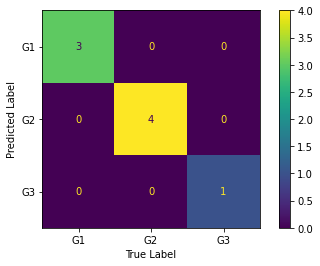

In [25]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(y_val, predict,labels=[0,1,2]),
                       display_labels=["G1","G2", "G3"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [26]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

03-06-2022 23:22:29 Uploading figures


In [ ]:
run.finish()

Acc,1.0
F1,1.0
Precision,1.0
Recall,1.0


# **4.0 Hyperparameter Tuning**

In [27]:
# global seed
seed = 41

In [28]:
sweep_config = {
    # try grid or random
    "method": "grid", #Como o número de combinações não é tão grande, vamos de grid pois o custo comp não será tão alto.
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="decision_tree")

Create sweep with ID: h4pnzr1x
Sweep URL: https://wandb.ai/juliaguardiani/decision_tree/sweeps/h4pnzr1x


In [29]:
# To see all parameters of a specific step of the pipeline
pipe.named_steps['KBest'].get_params()

{'k': 20,
 'score_func': <function sklearn.feature_selection._univariate_selection.chi2>}

In [ ]:
pipe.named_steps['classifier'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [30]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [("KBest", SelectKBest(chi2, k=20)),
                                 ("classifier",DecisionTreeClassifier()) ]
                        )

        # update the parameters of the pipeline that we would like to tuning

        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})
      
        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1, average='micro')
        precision = precision_score(y_val, predict, zero_division=1, average='micro')
        recall = recall_score(y_val, predict, zero_division=1, average='micro')
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=8) 

# **5.0 Configure and train the best model**

In [ ]:
run = wandb.init()

Runtime >> Factory reset runtime 

desconectar e excluir ambiente

In [12]:
# The full pipeline 
pipe = Pipeline(steps = [("KBest", SelectKBest(chi2, k=20)),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1, average='micro')
precision = precision_score(y_val, predict, zero_division=1, average='micro')
recall = recall_score(y_val, predict, zero_division=1, average='micro')
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

03-06-2022 23:28:07 Training
03-06-2022 23:28:07 Infering
03-06-2022 23:28:07 Evaluation metrics
03-06-2022 23:28:07 Accuracy: 1.0
03-06-2022 23:28:07 Precision: 1.0
03-06-2022 23:28:07 Recall: 1.0
03-06-2022 23:28:07 F1: 1.0


# **6.0 Export the best model**

In [13]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [14]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

03-06-2022 23:28:16 Dumping the artifacts to disk


['target_encoder']

In [15]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

03-06-2022 23:28:19 Logging model artifact


In [16]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

03-06-2022 23:28:29 Logging target enconder artifact


In [17]:
run.finish()

Acc,1.0
F1,1.0
Precision,1.0
Recall,1.0
